# Deep Learning Applications: Laboratory #1

In this first laboratory we will work with relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to create **your** solution.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [7]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from functools import reduce
from dataclasses import dataclass, field
from typing import List, Optional, Callable, Dict, Any

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim import Adam, SGD

# Torchvision imports

from torchvision.datasets import MNIST, CIFAR10

# Third-party imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import wandb
from tqdm import tqdm

# Import moduli locali
from src.models import MLP, ResidualMLP, SimpleCNN, ResidualCNN
from src.trainer import StreamlinedTrainer
from src.data import get_data_transforms, TransformedSubset
from src.utils import compute_accuracy_metrics
from src.config import TrainingConfig

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [8]:
# # Standard MNIST transform.
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
# ])

# # Load MNIST train and test.
# ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
# ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# # Split train into train and validation.
# val_size = 5000
# I = np.random.permutation(len(ds_train))
# ds_val = Subset(ds_train, I[:val_size])
# ds_train = Subset(ds_train, I[val_size:])

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [9]:
# from tqdm import tqdm
# from sklearn.metrics import accuracy_score, classification_report

# # Function to train a model for a single epoch over the data loader.
# def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
#     model.train()
#     losses = []
#     for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
#         xs = xs.to(device)
#         ys = ys.to(device)
#         opt.zero_grad()
#         logits = model(xs)
#         loss = F.cross_entropy(logits, ys)
#         loss.backward()
#         opt.step()
#         losses.append(loss.item())
#     return np.mean(losses)

# # Function to evaluate model over all samples in the data loader.
# def evaluate_model(model, dl, device='cpu'):
#     model.eval()
#     predictions = []
#     gts = []
#     for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
#         xs = xs.to(device)
#         preds = torch.argmax(model(xs), dim=1)
#         gts.append(ys)
#         predictions.append(preds.detach().cpu().numpy())

#     # Return accuracy score and classification report.
#     return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
#             classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# # Simple function to plot the loss curve and validation accuracy.
# def plot_validation_curves(losses_and_accs):
#     losses = [x for (x, _) in losses_and_accs]
#     accs = [x for (_, x) in losses_and_accs]
#     plt.figure(figsize=(16, 8))
#     plt.subplot(1, 2, 1)
#     plt.plot(losses)
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Average Training Loss per Epoch')
#     plt.subplot(1, 2, 2)
#     plt.plot(accs)
#     plt.xlabel('Epoch')
#     plt.ylabel('Validation Accuracy')
#     plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [10]:
# class MLP(nn.Module):
#     def __init__(self, layer_sizes):
#         super().__init__()
#         self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])

#     def forward(self, x):
#         return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

In [11]:
# # Training hyperparameters.
# device = 'cuda' if torch.cuda.is_available else 'cpu'
# epochs = 100
# lr = 0.0001
# batch_size = 128

# # Architecture hyperparameters.
# input_size = 28*28
# width = 16
# depth = 2

# # Dataloaders.
# dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
# dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
# dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# # Instantiate model and optimizer.
# model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
# opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# # Training loop.
# losses_and_accs = []
# for epoch in range(epochs):
#     loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
#     (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
#     losses_and_accs.append((loss, val_acc))

# # And finally plot the curves.
# plot_validation_curves(losses_and_accs)
# print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

#### My Streamlined Training Pipeline

In [12]:
from typing import List, Optional, Callable, Any, Dict
from torch import nn
from torchvision import transforms
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import wandb
import os
import copy

# Le classi TrainingConfig, get_data_transforms, TransformedSubset e StreamlinedTrainer sono ora importate dai moduli locali.
# Utilizza direttamente queste classi e funzioni per la configurazione, la preparazione dei dati e il training.



### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

#### Training Configuration

In [ ]:
# Load datasets
ds_train = MNIST(root='./data', train=True, download=True)
ds_test = MNIST(root='./data', train=False, download=True)

# Create streamlined training configuration
config = TrainingConfig(
    num_epochs=60,
    batch_size=256,
    learning_rate=1e-3,
    use_early_stopping=True,
    early_stopping_patience=10,
    validation_split=0.1,
    data_augmentation=["RandomRotation", "RandomAffine"],
    wandb_project="DeepLearningApplication_Lab1"
)

# Define model architecture
model = MLP(
    input_size=28 * 28,
    output_size=10,
    hidden_sizes=[128, 64],
    activation_fn=nn.ReLU,
    dropout_rate=0.1
)

# Create trainer and start training
trainer = StreamlinedTrainer(
    model=model,
    config=config,
    train_dataset=ds_train,
    test_dataset=ds_test,
    compute_metrics_fn=compute_accuracy_metrics
)

print(f"Model: {model}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

In [ ]:
# Start training
final_metrics = trainer.train()

### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case.

#### Training Loop

In [13]:


# Comparison between MLP and ResidualMLP with different depths
def compare_mlp_architectures():
    """Compare standard MLP vs ResidualMLP across different depths."""
    
    # Load datasets
    ds_train = MNIST(root='./data', train=True, download=True)
    ds_test = MNIST(root='./data', train=False, download=True)
    
    # Training configuration
    config = TrainingConfig(
        num_epochs=50,
        batch_size=256,
        learning_rate=1e-3,
        use_early_stopping=True,
        early_stopping_patience=8,
        wandb_project="MLP_vs_ResidualMLP_Comparison"
    )
    
    # Test different architectures
    architectures = [
        {"hidden_sizes": [128, 64], "name": "shallow"},
        {"hidden_sizes": [128, 64, 64, 32], "name": "medium"},
        {"hidden_sizes": [128, 128, 64, 64, 32, 32, 16, 16], "name": "deep"}
    ]
    
    results = {}
    
    for arch in architectures:
        print(f"\n{'='*50}")
        print(f"Testing {arch['name']} architecture")
        print(f"{'='*50}")
        
        # Standard MLP
        mlp = MLP(
            input_size=28 * 28,
            output_size=10,
            hidden_sizes=arch["hidden_sizes"],
            dropout_rate=0.1
        )
        
        print(f"\n--- Standard MLP ---")
        print(f"Parameters: {sum(p.numel() for p in mlp.parameters()):,}")
        
        trainer_mlp = StreamlinedTrainer(
            model=mlp,
            config=config,
            train_dataset=ds_train,
            test_dataset=ds_test,
            compute_metrics_fn=compute_accuracy_metrics
        )
        
        # mlp_metrics = trainer_mlp.train()
        
        # ResidualMLP (approximate same complexity)
        res_mlp = ResidualMLP(
            input_size=28 * 28,
            output_size=10,
            hidden_sizes=arch["hidden_sizes"],  # Use first hidden size
            # num_blocks=3,
            layers_per_block=2,
            dropout_rate=0.1
        )
        
        print(f"\n--- Residual MLP ---")
        print(f"Parameters: {sum(p.numel() for p in res_mlp.parameters()):,}")
        
        trainer_res = StreamlinedTrainer(
            model=res_mlp,
            config=config,
            train_dataset=ds_train,
            test_dataset=ds_test,
            compute_metrics_fn=compute_accuracy_metrics
        )
        
        res_metrics = trainer_res.train()
        
        # Store results
        results[arch["name"]] = {
            # "mlp": mlp_metrics,
            "residual_mlp": res_metrics
        }
        
        print(f"\n--- Results Summary for {arch['name']} ---")
        # print(f"Standard MLP Test Accuracy: {mlp_metrics['accuracy']:.4f}")
        print(f"Residual MLP Test Accuracy: {res_metrics['accuracy']:.4f}")
    
    return results

# Run the comparison
results = compare_mlp_architectures()

100%|██████████| 9.91M/9.91M [00:03<00:00, 3.27MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 262kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.98MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.13MB/s]



Testing deep architecture

--- Residual MLP ---
Parameters: 288,858
Training set size: 54000
Validation set size: 6000


wandb: Currently logged in as: vincenzo-civale (vincenzo-civale-universi-degli-studi-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting training for 50 epochs
Device: cuda
Batch size: 256

Epoch 1/50


Train Loss: 0.8463, Val Metrics: {'loss': 0.2372329713155826, 'accuracy': 0.9288333333333333}
✓ Best model updated!

Epoch 2/50


Train Loss: 0.3774, Val Metrics: {'loss': 0.16399366905291876, 'accuracy': 0.9515}
✓ Best model updated!

Epoch 3/50


Train Loss: 0.2942, Val Metrics: {'loss': 0.14236839643369117, 'accuracy': 0.9571666666666667}
✓ Best model updated!

Epoch 4/50


Train Loss: 0.2586, Val Metrics: {'loss': 0.1164295553850631, 'accuracy': 0.9628333333333333}
✓ Best model updated!

Epoch 5/50


Train Loss: 0.2260, Val Metrics: {'loss': 0.10444438938672344, 'accuracy': 0.9685}
✓ Best model updated!

Epoch 6/50


Train Loss: 0.2084, Val Metrics: {'loss': 0.09465558671702941, 'accuracy': 0.9698333333333333}
✓ Best model updated!

Epoch 7/50


Train Loss: 0.1992, Val Metrics: {'loss': 0.09392463943610589, 'accuracy': 0.9718333333333333}
✓ Best model updated!

Epoch 8/50


Train Loss: 0.1889, Val Metrics: {'loss': 0.08381033362820745, 'accuracy': 0.9771666666666666}
✓ Best model updated!

Epoch 9/50


Train Loss: 0.1757, Val Metrics: {'loss': 0.07314414624124765, 'accuracy': 0.9785}
✓ Best model updated!

Epoch 10/50


Train Loss: 0.1645, Val Metrics: {'loss': 0.0701708741641293, 'accuracy': 0.98}
✓ Best model updated!

Epoch 11/50


Train Loss: 0.1612, Val Metrics: {'loss': 0.07255637925118208, 'accuracy': 0.977}
No improvement for 1 epochs

Epoch 12/50


Train Loss: 0.1594, Val Metrics: {'loss': 0.08282934843252103, 'accuracy': 0.9756666666666667}
No improvement for 2 epochs

Epoch 13/50


Train Loss: 0.1544, Val Metrics: {'loss': 0.07438798590252797, 'accuracy': 0.9778333333333333}
No improvement for 3 epochs

Epoch 14/50


Train Loss: 0.1467, Val Metrics: {'loss': 0.07598179679674406, 'accuracy': 0.9778333333333333}
No improvement for 4 epochs

Epoch 15/50


Train Loss: 0.1464, Val Metrics: {'loss': 0.07787667129499216, 'accuracy': 0.9773333333333334}
No improvement for 5 epochs

Epoch 16/50


Train Loss: 0.1460, Val Metrics: {'loss': 0.0608606212772429, 'accuracy': 0.9813333333333333}
✓ Best model updated!

Epoch 17/50


Train Loss: 0.1387, Val Metrics: {'loss': 0.07198872386167447, 'accuracy': 0.9785}
No improvement for 1 epochs

Epoch 18/50


Train Loss: 0.1393, Val Metrics: {'loss': 0.06293495441786945, 'accuracy': 0.9821666666666666}
✓ Best model updated!

Epoch 19/50


Train Loss: 0.1307, Val Metrics: {'loss': 0.059453672962263227, 'accuracy': 0.9818333333333333}
No improvement for 1 epochs

Epoch 20/50


Train Loss: 0.1321, Val Metrics: {'loss': 0.0592791591770947, 'accuracy': 0.9826666666666667}
✓ Best model updated!

Epoch 21/50


Train Loss: 0.1308, Val Metrics: {'loss': 0.06148649853033324, 'accuracy': 0.9816666666666667}
No improvement for 1 epochs

Epoch 22/50


Train Loss: 0.1260, Val Metrics: {'loss': 0.06995412769416968, 'accuracy': 0.9795}
No improvement for 2 epochs

Epoch 23/50


Train Loss: 0.1259, Val Metrics: {'loss': 0.05982002588765075, 'accuracy': 0.9823333333333333}
No improvement for 3 epochs

Epoch 24/50


Train Loss: 0.1221, Val Metrics: {'loss': 0.05935899338995417, 'accuracy': 0.9843333333333333}
✓ Best model updated!

Epoch 25/50


Train Loss: 0.1218, Val Metrics: {'loss': 0.054836902456978955, 'accuracy': 0.9838333333333333}
No improvement for 1 epochs

Epoch 26/50


Train Loss: 0.1186, Val Metrics: {'loss': 0.05421651007297138, 'accuracy': 0.984}
No improvement for 2 epochs

Epoch 27/50


Train Loss: 0.1156, Val Metrics: {'loss': 0.05346318784480294, 'accuracy': 0.984}
No improvement for 3 epochs

Epoch 28/50


Train Loss: 0.1184, Val Metrics: {'loss': 0.05713686936845382, 'accuracy': 0.984}
No improvement for 4 epochs

Epoch 29/50


Train Loss: 0.1156, Val Metrics: {'loss': 0.05035244983931383, 'accuracy': 0.9855}
✓ Best model updated!

Epoch 30/50


Train Loss: 0.1119, Val Metrics: {'loss': 0.05357906400846938, 'accuracy': 0.9855}
No improvement for 1 epochs

Epoch 31/50


Train Loss: 0.1145, Val Metrics: {'loss': 0.05062254099175334, 'accuracy': 0.9848333333333333}
No improvement for 2 epochs

Epoch 32/50


Train Loss: 0.1193, Val Metrics: {'loss': 0.05511826633786162, 'accuracy': 0.9826666666666667}
No improvement for 3 epochs

Epoch 33/50


Train Loss: 0.1134, Val Metrics: {'loss': 0.05225319124292582, 'accuracy': 0.9855}
No improvement for 4 epochs

Epoch 34/50


Train Loss: 0.1087, Val Metrics: {'loss': 0.05230710686494907, 'accuracy': 0.986}
✓ Best model updated!

Epoch 35/50


Train Loss: 0.1095, Val Metrics: {'loss': 0.05309020487281183, 'accuracy': 0.9851666666666666}
No improvement for 1 epochs

Epoch 36/50


Train Loss: 0.1086, Val Metrics: {'loss': 0.04797486437018961, 'accuracy': 0.9866666666666667}
✓ Best model updated!

Epoch 37/50


Train Loss: 0.1075, Val Metrics: {'loss': 0.04991334715547661, 'accuracy': 0.9853333333333333}
No improvement for 1 epochs

Epoch 38/50


Train Loss: 0.1034, Val Metrics: {'loss': 0.05303500441368669, 'accuracy': 0.9855}
No improvement for 2 epochs

Epoch 39/50


Train Loss: 0.1052, Val Metrics: {'loss': 0.05470810617165019, 'accuracy': 0.9848333333333333}
No improvement for 3 epochs

Epoch 40/50


Train Loss: 0.1037, Val Metrics: {'loss': 0.050399146896476545, 'accuracy': 0.9853333333333333}
No improvement for 4 epochs

Epoch 41/50


Train Loss: 0.1022, Val Metrics: {'loss': 0.05605795878606538, 'accuracy': 0.9841666666666666}
No improvement for 5 epochs

Epoch 42/50


Train Loss: 0.1017, Val Metrics: {'loss': 0.05166121490765363, 'accuracy': 0.9856666666666667}
No improvement for 6 epochs

Epoch 43/50


Train Loss: 0.1052, Val Metrics: {'loss': 0.05024113261606544, 'accuracy': 0.9855}
No improvement for 7 epochs

Epoch 44/50


Train Loss: 0.1041, Val Metrics: {'loss': 0.05264192831236869, 'accuracy': 0.986}
No improvement for 8 epochs
Early stopping triggered after 44 epochs
Loading best model weights



Final Test Metrics: {'loss': 0.035525467780826145, 'accuracy': 0.987}

--- Results Summary for deep ---
Residual MLP Test Accuracy: 0.9870


### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving.

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [ ]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    """
    A simple CNN with configurable depth for image classification.
    
    Args:
        in_channels: Number of input channels (1 for MNIST, 3 for CIFAR)
        num_classes: Number of output classes
        depth: Number of convolutional blocks
        initial_channels: Number of channels in first conv layer
    """
    
    def __init__(self, in_channels: int = 3, num_classes: int = 10, depth: int = 3, initial_channels: int = 16):
        super().__init__()
        
        self.depth = depth
        self.initial_channels = initial_channels
        self.in_channels = in_channels
        self.num_classes = num_classes
        
        # Build feature extractor
        layers = []
        current_channels = initial_channels
        
        # Stem layer
        layers.extend([
            nn.Conv2d(in_channels, current_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(current_channels),
            nn.ReLU(inplace=True)
        ])
        
        # Convolutional blocks with downsampling
        for i in range(depth):
            next_channels = current_channels * 2
            layers.extend([
                nn.Conv2d(current_channels, next_channels, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(next_channels),
                nn.ReLU(inplace=True)
            ])
            current_channels = next_channels
        
        self.features = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(current_channels, num_classes)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)
    
    def __str__(self) -> str:
        return f"simplecnn_ch{self.initial_channels}_d{self.depth}_c{self.num_classes}"


#### Training Loop with CIFAR10

In [ ]:
def compare_cnn_architectures():
    """Compare SimpleCNN vs ResidualCNN on CIFAR-10."""
    
    # CIFAR-10 specific transforms
    def get_cifar_transforms(is_training: bool = True):
        if is_training:
            return transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
        else:
            return transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
    
    # Override transforms for CIFAR-10
    def get_data_transforms_cifar(config, is_training=True):
        return get_cifar_transforms(is_training)
    
    # Load CIFAR-10 datasets  
    ds_train = CIFAR10(root='./data', train=True, download=True)
    ds_test = CIFAR10(root='./data', train=False, download=True)
    
    # Configuration for CIFAR-10
    config = TrainingConfig(
        num_epochs=60,
        batch_size=128,  # Smaller batch size for CIFAR-10
        learning_rate=1e-3,
        use_early_stopping=True,
        early_stopping_patience=10,
        validation_split=0.1,
        data_augmentation=[],  # We handle augmentation in transforms
        wandb_project="CNN_Comparison_CIFAR10"
    )
    
    depths = [2, 3, 4]
    results = {}
    
    for depth in depths:
        print(f"\n{'='*50}")
        print(f"Testing depth {depth}")
        print(f"{'='*50}")
        
        # Simple CNN
        simple_cnn = SimpleCNN(
            in_channels=3,
            num_classes=10,
            depth=depth,
            initial_channels=32
        )
        
        print(f"\n--- Simple CNN (depth {depth}) ---")
        print(f"Parameters: {sum(p.numel() for p in simple_cnn.parameters()):,}")
        
        # Temporarily override transform function for CIFAR-10
        import types
        trainer_simple = StreamlinedTrainer(
            model=simple_cnn,
            config=config,
            train_dataset=ds_train,
            test_dataset=ds_test,
            compute_metrics_fn=compute_accuracy_metrics
        )
        
        # Override the transform creation method for CIFAR-10
        trainer_simple._setup_data_loaders = types.MethodType(
            lambda self, train_dataset: self._setup_cifar_loaders(train_dataset), 
            trainer_simple
        )
        trainer_simple._setup_test_loader = types.MethodType(
            lambda self, test_dataset: self._setup_cifar_test_loader(test_dataset), 
            trainer_simple
        )
        
        # Add CIFAR-specific methods
        def _setup_cifar_loaders(self, train_dataset):
            targets = np.array(train_dataset.targets)
            train_indices, val_indices = train_test_split(
                np.arange(len(targets)), test_size=self.config.validation_split,
                stratify=targets, random_state=self.config.seed
            )
            
            train_subset = TransformedSubset(train_dataset, train_indices, get_cifar_transforms(True))
            val_subset = TransformedSubset(train_dataset, val_indices, get_cifar_transforms(False))
            
            train_loader = DataLoader(train_subset, batch_size=self.config.batch_size, 
                                    shuffle=True, num_workers=self.config.num_workers, 
                                    pin_memory=self.config.pin_memory)
            val_loader = DataLoader(val_subset, batch_size=self.config.batch_size, 
                                  shuffle=False, num_workers=self.config.num_workers, 
                                  pin_memory=self.config.pin_memory)
            
            print(f"Training set size: {len(train_subset)}")
            print(f"Validation set size: {len(val_subset)}")
            return train_loader, val_loader
        
        def _setup_cifar_test_loader(self, test_dataset):
            class TransformedDataset(Dataset):
                def __init__(self, dataset, transform):
                    self.dataset = dataset
                    self.transform = transform
                def __len__(self):
                    return len(self.dataset)
                def __getitem__(self, idx):
                    img, label = self.dataset[idx]
                    return self.transform(img), label
            
            transformed_test = TransformedDataset(test_dataset, get_cifar_transforms(False))
            return DataLoader(transformed_test, batch_size=self.config.batch_size, 
                            shuffle=False, num_workers=self.config.num_workers, 
                            pin_memory=self.config.pin_memory)
        
        trainer_simple._setup_cifar_loaders = types.MethodType(_setup_cifar_loaders, trainer_simple)
        trainer_simple._setup_cifar_test_loader = types.MethodType(_setup_cifar_test_loader, trainer_simple)
        
        # Re-setup dataloaders with CIFAR transforms
        trainer_simple.train_loader, trainer_simple.val_loader = trainer_simple._setup_cifar_loaders(ds_train)
        trainer_simple.test_loader = trainer_simple._setup_cifar_test_loader(ds_test)
        
        simple_metrics = trainer_simple.train()
        
        # Residual CNN
        residual_cnn = ResidualCNN(
            in_channels=3,
            num_classes=10,
            depth=depth,
            initial_channels=32
        )
        
        print(f"\n--- Residual CNN (depth {depth}) ---")
        print(f"Parameters: {sum(p.numel() for p in residual_cnn.parameters()):,}")
        
        trainer_res = StreamlinedTrainer(
            model=residual_cnn,
            config=config,
            train_dataset=ds_train,
            test_dataset=ds_test,
            compute_metrics_fn=compute_accuracy_metrics
        )
        
        # Apply same CIFAR-10 specific setup
        trainer_res._setup_cifar_loaders = types.MethodType(_setup_cifar_loaders, trainer_res)
        trainer_res._setup_cifar_test_loader = types.MethodType(_setup_cifar_test_loader, trainer_res)
        trainer_res.train_loader, trainer_res.val_loader = trainer_res._setup_cifar_loaders(ds_train)
        trainer_res.test_loader = trainer_res._setup_cifar_test_loader(ds_test)
        
        res_metrics = trainer_res.train()
        
        # Store results
        results[depth] = {
            "simple_cnn": simple_metrics,
            "residual_cnn": res_metrics
        }
        
        print(f"\n--- Results Summary for depth {depth} ---")
        print(f"Simple CNN Test Accuracy: {simple_metrics['accuracy']:.4f}")
        print(f"Residual CNN Test Accuracy: {res_metrics['accuracy']:.4f}")
    
    return results

# Run the comparison (uncomment to execute)
results = compare_cnn_architectures()

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

## Exercise 2.2: Knowledge Distillation

In this exercise, we'll implement knowledge distillation to transfer knowledge from a large **teacher** model to a smaller **student** model.

**Steps:**
1. Train a ResidualCNN with depth 4 as the **teacher** model
2. Create a smaller **student** model with ~half the parameters  
3. Train the student using both hard labels and soft labels from the teacher

In [3]:
### Step 1: Train the Teacher Model (ResidualCNN depth=4)

cifar10_train = CIFAR10(root='./data', train=True, download=True)
cifar10_test = CIFAR10(root='./data', train=False, download=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create teacher model
teacher_model = ResidualCNN(depth=4, num_classes=10)
print(f"Teacher model parameters: {sum(p.numel() for p in teacher_model.parameters()):,}")

# Create configuration for teacher training
teacher_config = TrainingConfig(
    num_epochs=15,
    batch_size=128,
    learning_rate=0.001,
    weight_decay=1e-4,
    loss_fn=nn.CrossEntropyLoss(),
    device=device,
    use_wandb=True,
    wandb_project="dl-lab1-knowledge-distillation",
    use_early_stopping=True,
    early_stopping_patience=5,
    early_stopping_metric="accuracy",
    maximize_metric=True,
    output_dir="models/"
)

# Train teacher model
print("Training teacher model...")
teacher_trainer = StreamlinedTrainer(
    model=teacher_model,
    config=teacher_config,
    train_dataset=cifar10_train,
    test_dataset=cifar10_test
)

teacher_results = teacher_trainer.train()
print(f"\nTeacher model test accuracy: {teacher_results['accuracy']:.4f}")

# Save teacher model and store results
teacher_path = teacher_trainer.save_model("teacher")
teacher_model_state = teacher_model.state_dict().copy()
teacher_accuracy = teacher_results['accuracy']

Teacher model parameters: 2,793,114
Training teacher model...
Training set size: 45000
Validation set size: 5000


wandb: Currently logged in as: vincenzo-civale (vincenzo-civale-universi-degli-studi-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting training for 15 epochs
Device: cuda
Batch size: 128

Epoch 1/15


Train Loss: 1.5340, Val Metrics: {'loss': 1.2635868400335313, 'accuracy': 0.5462}
✓ Best model updated!

Epoch 2/15


Train Loss: 1.2023, Val Metrics: {'loss': 1.074976746737957, 'accuracy': 0.6298}
✓ Best model updated!

Epoch 3/15


Train Loss: 1.0197, Val Metrics: {'loss': 0.9488953307271004, 'accuracy': 0.6704}
✓ Best model updated!

Epoch 4/15


Train Loss: 0.9014, Val Metrics: {'loss': 0.7755203813314437, 'accuracy': 0.7304}
✓ Best model updated!

Epoch 5/15


Train Loss: 0.8267, Val Metrics: {'loss': 0.7082339152693748, 'accuracy': 0.7504}
✓ Best model updated!

Epoch 6/15


Train Loss: 0.7570, Val Metrics: {'loss': 0.6670993015170097, 'accuracy': 0.7724}
✓ Best model updated!

Epoch 7/15


Train Loss: 0.7132, Val Metrics: {'loss': 0.6120938830077648, 'accuracy': 0.7834}
✓ Best model updated!

Epoch 8/15


Train Loss: 0.6761, Val Metrics: {'loss': 0.6535413131117821, 'accuracy': 0.777}
No improvement for 1 epochs

Epoch 9/15


Train Loss: 0.6389, Val Metrics: {'loss': 0.5610129199922085, 'accuracy': 0.8074}
✓ Best model updated!

Epoch 10/15


Train Loss: 0.6075, Val Metrics: {'loss': 0.6785904765129089, 'accuracy': 0.7712}
No improvement for 1 epochs

Epoch 11/15


Train Loss: 0.5799, Val Metrics: {'loss': 0.5659338288009167, 'accuracy': 0.8034}
No improvement for 2 epochs

Epoch 12/15


Train Loss: 0.5631, Val Metrics: {'loss': 0.5993236765265465, 'accuracy': 0.8004}
No improvement for 3 epochs

Epoch 13/15


Train Loss: 0.5373, Val Metrics: {'loss': 0.5487134583294392, 'accuracy': 0.8142}
✓ Best model updated!

Epoch 14/15


Train Loss: 0.5211, Val Metrics: {'loss': 0.5354428112506866, 'accuracy': 0.8228}
✓ Best model updated!

Epoch 15/15


Train Loss: 0.5019, Val Metrics: {'loss': 0.5323229275643826, 'accuracy': 0.8208}
No improvement for 1 epochs
Loading best model weights



Final Test Metrics: {'loss': 0.5461378218252447, 'accuracy': 0.8164}

Teacher model test accuracy: 0.8164
Model saved to models/rescnn_ch16_d4_c10_teacher.pth


In [4]:
### Step 2: Create and Train Student Model (smaller version)

# Create student model with ~half the parameters
student_model = ResidualCNN(depth=2,  num_classes=10)  # Reduced depth and width
print(f"Student model parameters: {sum(p.numel() for p in student_model.parameters()):,}")
print(f"Parameter reduction: {sum(p.numel() for p in student_model.parameters()) / sum(p.numel() for p in teacher_model.parameters()):.2%}")

# Train student model without distillation
student_config = TrainingConfig(
    num_epochs=15,
    batch_size=128,
    learning_rate=0.001,
    weight_decay=1e-4,
    loss_fn=nn.CrossEntropyLoss(),
    device=device,
    use_wandb=True,
    wandb_project="dl-lab1-knowledge-distillation",
    use_early_stopping=True,
    early_stopping_patience=5,
    early_stopping_metric="accuracy",
    maximize_metric=True,
    output_dir="models/"
)

print("Training student model (without distillation)...")
student_trainer = StreamlinedTrainer(
    model=student_model,
    config=student_config,
    train_dataset=cifar10_train,
    test_dataset=cifar10_test
)

student_baseline_results = student_trainer.train()
print(f"\nStudent baseline test accuracy: {student_baseline_results['accuracy']:.4f}")

# Save student baseline
student_baseline_path = student_trainer.save_model("student_baseline")
student_baseline_accuracy = student_baseline_results['accuracy']

Student model parameters: 165,914
Parameter reduction: 5.94%
Training student model (without distillation)...
Training set size: 45000
Validation set size: 5000


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


test/accuracy,▁
test/loss,▁
train/train_loss,██▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val/accuracy,▁▃▄▆▆▇▇▇█▇█▇███
val/loss,█▆▅▃▃▂▂▂▁▂▁▂▁▁▁
test/accuracy,0.8164
test/loss,0.54614
train/train_loss,0.49944
val/accuracy,0.8208
val/loss,0.53232


Starting training for 15 epochs
Device: cuda
Batch size: 128

Epoch 1/15


Train Loss: 1.5143, Val Metrics: {'loss': 1.2407567590475082, 'accuracy': 0.5504}
✓ Best model updated!

Epoch 2/15


Train Loss: 1.1961, Val Metrics: {'loss': 1.1029451370239258, 'accuracy': 0.6088}
✓ Best model updated!

Epoch 3/15


Train Loss: 1.0453, Val Metrics: {'loss': 1.0837183237075805, 'accuracy': 0.613}
✓ Best model updated!

Epoch 4/15


Train Loss: 0.9569, Val Metrics: {'loss': 0.9742089167237282, 'accuracy': 0.6594}
✓ Best model updated!

Epoch 5/15


Train Loss: 0.8898, Val Metrics: {'loss': 0.8519542336463928, 'accuracy': 0.7024}
✓ Best model updated!

Epoch 6/15


Train Loss: 0.8233, Val Metrics: {'loss': 0.7638009175658226, 'accuracy': 0.733}
✓ Best model updated!

Epoch 7/15


Train Loss: 0.7851, Val Metrics: {'loss': 0.8307042688131332, 'accuracy': 0.7124}
No improvement for 1 epochs

Epoch 8/15


Train Loss: 0.7479, Val Metrics: {'loss': 0.7266128897666931, 'accuracy': 0.7528}
✓ Best model updated!

Epoch 9/15


Train Loss: 0.7125, Val Metrics: {'loss': 0.6902000844478607, 'accuracy': 0.7646}
✓ Best model updated!

Epoch 10/15


Train Loss: 0.6795, Val Metrics: {'loss': 0.86166403144598, 'accuracy': 0.7192}
No improvement for 1 epochs

Epoch 11/15


Train Loss: 0.6551, Val Metrics: {'loss': 0.694909043610096, 'accuracy': 0.766}
✓ Best model updated!

Epoch 12/15


Train Loss: 0.6367, Val Metrics: {'loss': 0.691471978276968, 'accuracy': 0.7664}
✓ Best model updated!

Epoch 13/15


Train Loss: 0.6202, Val Metrics: {'loss': 0.5978748992085456, 'accuracy': 0.7922}
✓ Best model updated!

Epoch 14/15


Train Loss: 0.6011, Val Metrics: {'loss': 0.6620557852089405, 'accuracy': 0.769}
No improvement for 1 epochs

Epoch 15/15


Train Loss: 0.5846, Val Metrics: {'loss': 0.625201053917408, 'accuracy': 0.7804}
No improvement for 2 epochs
Loading best model weights



Final Test Metrics: {'loss': 0.6288939273055596, 'accuracy': 0.7833}

Student baseline test accuracy: 0.7833
Model saved to models/rescnn_ch16_d2_c10_student_baseline.pth


In [5]:
### Step 3: Knowledge Distillation Training

# Create a custom trainer for knowledge distillation
class KnowledgeDistillationTrainer(StreamlinedTrainer):
    def __init__(self, student_model, teacher_model, config, train_dataset, test_dataset, 
                 temperature=3.0, alpha=0.7, compute_metrics_fn=None):
        # Initialize parent with student model
        super().__init__(student_model, config, train_dataset, test_dataset, compute_metrics_fn)
        
        
        self.teacher_model = teacher_model
        self.teacher_model.to(config.device)
        self.teacher_model.eval()  # Teacher is always in eval mode
        
        # Distillation parameters
        self.temperature = temperature
        self.alpha = alpha  # Weight for distillation loss
        
        # Loss functions
        self.hard_loss_fn = nn.CrossEntropyLoss()
        self.soft_loss_fn = nn.KLDivLoss(reduction='batchmean')
        
    def train_epoch(self):
        self.model.train()
        self.teacher_model.eval()
        
        total_loss = 0.0
        total_hard_loss = 0.0
        total_soft_loss = 0.0
        num_batches = 0
        
        from tqdm import tqdm
        progress_bar = tqdm(self.train_loader, desc="Distillation Training", leave=False)
        
        for batch in progress_bar:
            inputs, labels = batch
            inputs, labels = inputs.to(self.config.device), labels.to(self.config.device)
            
            self.optimizer.zero_grad()
            
            # Forward pass through student
            student_outputs = self.model(inputs)
            
            # Forward pass through teacher (no gradients)
            with torch.no_grad():
                teacher_outputs = self.teacher_model(inputs)
            
            # Calculate losses using the distillation_loss function from models.py
            loss, hard_loss, soft_loss = distillation_loss(
                student_outputs, teacher_outputs, labels,
                temperature=self.temperature, alpha=self.alpha
            )
            
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            total_hard_loss += hard_loss.item()
            total_soft_loss += soft_loss.item()
            num_batches += 1
            self.global_step += 1
            
            avg_total_loss = total_loss / num_batches
            avg_hard_loss = total_hard_loss / num_batches
            avg_soft_loss = total_soft_loss / num_batches
            
            progress_bar.set_postfix({
                "total": f"{avg_total_loss:.4f}",
                "hard": f"{avg_hard_loss:.4f}", 
                "soft": f"{avg_soft_loss:.4f}"
            })
            
            if self.config.logging_steps > 0 and self.global_step % self.config.logging_steps == 0:
                self._log_metrics({
                    "train_loss": avg_total_loss,
                    "train_hard_loss": avg_hard_loss,
                    "train_soft_loss": avg_soft_loss
                }, "train/")
        
        return total_loss / num_batches

print("Knowledge Distillation Trainer created!")

Knowledge Distillation Trainer created!


In [8]:
# Define the distillation loss function
def distillation_loss(student_logits, teacher_logits, labels, temperature=3.0, alpha=0.7):
    """
    Calculate the knowledge distillation loss.
    
    Args:
        student_logits: Logits from the student model
        teacher_logits: Logits from the teacher model
        labels: True labels
        temperature: Temperature to soften the distributions
        alpha: Weight for soft targets loss vs hard targets loss
    
    Returns:
        total_loss: Combined loss
        hard_loss: Cross entropy with true labels
        soft_loss: KL divergence with teacher outputs
    """
    # Hard targets loss: standard cross-entropy with true labels
    hard_loss = F.cross_entropy(student_logits, labels)
    
    # Soft targets: apply temperature scaling and compute KL divergence
    soft_student = F.log_softmax(student_logits / temperature, dim=1)
    soft_teacher = F.softmax(teacher_logits / temperature, dim=1)
    soft_loss = F.kl_div(soft_student, soft_teacher, reduction='batchmean') * (temperature ** 2)
    
    # Combine the losses
    total_loss = (1 - alpha) * hard_loss + alpha * soft_loss
    
    return total_loss, hard_loss, soft_loss

# Create a fresh student model for distillation training
student_distilled = ResidualCNN(depth=2, num_classes=10)

# Load the trained teacher model
teacher_for_distillation = ResidualCNN(depth=4,num_classes=10)
teacher_for_distillation.load_state_dict(teacher_model_state)

# Configuration for distillation training
distillation_config = TrainingConfig(
    num_epochs=20,  # More epochs for distillation
    batch_size=128,
    learning_rate=0.001,
    weight_decay=1e-4,
    loss_fn=nn.CrossEntropyLoss(),  # This won't be used, but needed for parent class
    device=device,
    use_wandb=True,
    wandb_project="dl-lab1-knowledge-distillation",
    use_early_stopping=True,
    early_stopping_patience=7,
    early_stopping_metric="accuracy",
    maximize_metric=True,
    output_dir="models/"
)

# Train student with knowledge distillation
print("Training student model with knowledge distillation...")
distillation_trainer = KnowledgeDistillationTrainer(
    student_model=student_distilled,
    teacher_model=teacher_for_distillation,
    config=distillation_config,
    train_dataset=cifar10_train,
    test_dataset=cifar10_test,
    temperature=3.0,  # Temperature for softmax
    alpha=0.7  # Weight for distillation loss (0.7 distillation + 0.3 hard labels)
)

student_distilled_results = distillation_trainer.train()
print(f"\nStudent (distilled) test accuracy: {student_distilled_results['accuracy']:.4f}")

# Save distilled student model
distilled_path = distillation_trainer.save_model("student_distilled")
student_distilled_accuracy = student_distilled_results['accuracy']

Training student model with knowledge distillation...
Training set size: 45000
Validation set size: 5000


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Starting training for 20 epochs
Device: cuda
Batch size: 128

Epoch 1/20


Train Loss: 2.3990, Val Metrics: {'loss': 1.2793010100722313, 'accuracy': 0.5478}
✓ Best model updated!

Epoch 2/20


Train Loss: 1.4616, Val Metrics: {'loss': 1.297536963224411, 'accuracy': 0.5862}
✓ Best model updated!

Epoch 3/20


Train Loss: 1.0950, Val Metrics: {'loss': 1.0273622795939445, 'accuracy': 0.66}
✓ Best model updated!

Epoch 4/20


Train Loss: 0.9036, Val Metrics: {'loss': 0.7599977433681488, 'accuracy': 0.7408}
✓ Best model updated!

Epoch 5/20


Train Loss: 0.7933, Val Metrics: {'loss': 0.8985732704401016, 'accuracy': 0.7082}
No improvement for 1 epochs

Epoch 6/20


Train Loss: 0.7162, Val Metrics: {'loss': 0.8282651782035828, 'accuracy': 0.7318}
No improvement for 2 epochs

Epoch 7/20


Train Loss: 0.6682, Val Metrics: {'loss': 0.6434436678886414, 'accuracy': 0.7848}
✓ Best model updated!

Epoch 8/20


Train Loss: 0.6315, Val Metrics: {'loss': 0.7658638849854469, 'accuracy': 0.7448}
No improvement for 1 epochs

Epoch 9/20


Train Loss: 0.5975, Val Metrics: {'loss': 0.6051010750234127, 'accuracy': 0.7932}
✓ Best model updated!

Epoch 10/20


Train Loss: 0.5781, Val Metrics: {'loss': 0.7339943781495094, 'accuracy': 0.7642}
No improvement for 1 epochs

Epoch 11/20


Train Loss: 0.5565, Val Metrics: {'loss': 0.5964657738804817, 'accuracy': 0.7966}
✓ Best model updated!

Epoch 12/20


Train Loss: 0.5432, Val Metrics: {'loss': 0.5730176396667958, 'accuracy': 0.8028}
✓ Best model updated!

Epoch 13/20


Train Loss: 0.5314, Val Metrics: {'loss': 0.5959741652011872, 'accuracy': 0.7922}
No improvement for 1 epochs

Epoch 14/20


Train Loss: 0.5305, Val Metrics: {'loss': 0.6343463003635407, 'accuracy': 0.7734}
No improvement for 2 epochs

Epoch 15/20


Train Loss: 0.5002, Val Metrics: {'loss': 0.577999809384346, 'accuracy': 0.8042}
✓ Best model updated!

Epoch 16/20


Train Loss: 0.4899, Val Metrics: {'loss': 0.5442349627614022, 'accuracy': 0.8092}
✓ Best model updated!

Epoch 17/20


Train Loss: 0.4832, Val Metrics: {'loss': 0.5150509931147098, 'accuracy': 0.819}
✓ Best model updated!

Epoch 18/20


Train Loss: 0.4750, Val Metrics: {'loss': 0.5552622392773628, 'accuracy': 0.805}
No improvement for 1 epochs

Epoch 19/20


Train Loss: 0.4696, Val Metrics: {'loss': 0.5692136004567147, 'accuracy': 0.8032}
No improvement for 2 epochs

Epoch 20/20


Train Loss: 0.4655, Val Metrics: {'loss': 0.5811493121087551, 'accuracy': 0.7996}
No improvement for 3 epochs
Loading best model weights



Final Test Metrics: {'loss': 0.549058354353603, 'accuracy': 0.8095}

Student (distilled) test accuracy: 0.8095
Model saved to models/rescnn_ch16_d2_c10_student_distilled.pth


KNOWLEDGE DISTILLATION RESULTS
Teacher Model (ResidualCNN depth=4):     0.8164
Student Baseline (ResidualCNN depth=2):  0.7833
Student Distilled (ResidualCNN depth=2): 0.8095
Improvement from Knowledge Distillation: 0.0262 (2.62%)
Parameter reduction: 5.94% of teacher size


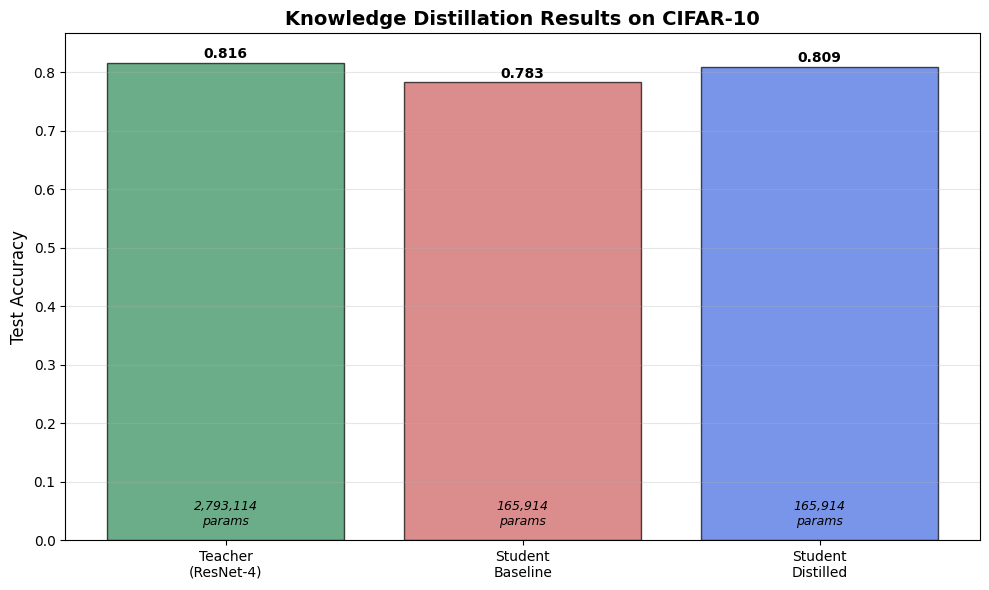


Knowledge distillation improved student performance by 0.0262!
   The distilled student achieved 0.8095 vs 0.7833 baseline

📊 Knowledge transfer efficiency: 99.2%
   (Student achieved 99.2% of teacher performance with 5.9% of parameters)


In [9]:
### Step 4: Compare Results

print("="*60)
print("KNOWLEDGE DISTILLATION RESULTS")
print("="*60)
print(f"Teacher Model (ResidualCNN depth=4):     {teacher_accuracy:.4f}")
print(f"Student Baseline (ResidualCNN depth=2):  {student_baseline_accuracy:.4f}")
print(f"Student Distilled (ResidualCNN depth=2): {student_distilled_accuracy:.4f}")
print("="*60)

improvement = student_distilled_accuracy - student_baseline_accuracy
print(f"Improvement from Knowledge Distillation: {improvement:.4f} ({improvement*100:.2f}%)")

# Calculate parameter reduction
teacher_params = sum(p.numel() for p in teacher_model.parameters())
student_params = sum(p.numel() for p in student_distilled.parameters())
print(f"Parameter reduction: {student_params/teacher_params:.2%} of teacher size")

# Visualize results
import matplotlib.pyplot as plt

models = ['Teacher\n(ResNet-4)', 'Student\nBaseline', 'Student\nDistilled']
accuracies = [teacher_accuracy, student_baseline_accuracy, student_distilled_accuracy]
colors = ['#2E8B57', '#CD5C5C', '#4169E1']

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Knowledge Distillation Results on CIFAR-10', fontsize=14, fontweight='bold')
plt.ylim(0, max(accuracies) + 0.05)
plt.grid(axis='y', alpha=0.3)

# Add parameter count annotations
param_counts = [teacher_params, student_params, student_params]
for i, (bar, params) in enumerate(zip(bars, param_counts)):
    plt.text(bar.get_x() + bar.get_width()/2., 0.02,
             f'{params:,}\nparams', ha='center', va='bottom', 
             fontsize=9, style='italic')

plt.tight_layout()
plt.show()

# Summary
if improvement > 0:
    print(f"\nKnowledge distillation improved student performance by {improvement:.4f}!")
    print(f"   The distilled student achieved {student_distilled_accuracy:.4f} vs {student_baseline_accuracy:.4f} baseline")
else:
    print(f"\nThe distilled student did not outperform the baseline.")
    print("   Try adjusting hyperparameters (temperature, alpha, learning rate, epochs)")
    
print(f"\n📊 Knowledge transfer efficiency: {(student_distilled_accuracy/teacher_accuracy)*100:.1f}%")
print(f"   (Student achieved {(student_distilled_accuracy/teacher_accuracy)*100:.1f}% of teacher performance with {student_params/teacher_params*100:.1f}% of parameters)")